In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

In [2]:
# Define file paths
mcq_path = "MCQ_J.xpt"   # Family history (already uploaded)        # Demographics (already uploaded)
demo_path = "DEMO_J.xpt" #demographics


# Load both datasets
mcq_df = pd.read_sas(mcq_path)
demo_df = pd.read_sas(demo_path)

In [3]:
readable_columns = {
    "SEQN": "Respondent_ID",
    "SDDSRVYR": "Survey_Cycle",
    "RIDSTATR": "Interview_Exam_Status",
    "RIAGENDR": "Gender",
    "RIDAGEYR": "Age_Years",
    "RIDAGEMN": "Age_Months_Screening",
    "RIDRETH1": "Race_Ethnicity",
    "RIDRETH3": "Race_Ethnicity_Asian",
    "RIDEXMON": "Exam_Period",
    "RIDEXAGM": "Age_Months_Exam",
    "DMQMILIZ": "Military_Service",
    "DMQADFC": "Served_Abroad",
    "DMDBORN4": "Country_of_Birth",
    "DMDCITZN": "Citizenship_Status",
    "DMDYRSUS": "Years_in_US",
    "DMDEDUC3": "Education_Level_6_19",
    "DMDEDUC2": "Education_Level_20+",
    "DMDMARTL": "Marital_Status",
    "RIDEXPRG": "Pregnancy_Status",
    "SIALANG": "SP_Interview_Language",
    "SIAPROXY": "SP_Interview_Proxy",
    "SIAINTRP": "SP_Interview_Interpreter",
    "FIALANG": "Family_Interview_Language",
    "FIAPROXY": "Family_Interview_Proxy",
    "FIAINTRP": "Family_Interview_Interpreter",
    "MIALANG": "MEC_Interview_Language",
    "MIAPROXY": "MEC_Interview_Proxy",
    "MIAINTRP": "MEC_Interview_Interpreter",
    "AIALANGA": "ACASI_Interview_Language",
    "DMDHHSIZ": "Household_Size",
    "DMDFMSIZ": "Family_Size",
    "DMDHHSZA": "Children_0_5_in_HH",
    "DMDHHSZB": "Children_6_17_in_HH",
    "DMDHHSZE": "Adults_60plus_in_HH",
    "DMDHRGND": "HH_Ref_Person_Gender",
    "DMDHRAGZ": "HH_Ref_Person_Age",
    "DMDHREDZ": "HH_Ref_Person_Education",
    "DMDHRMAZ": "HH_Ref_Person_Marital_Status",
    "DMDHSEDZ": "HH_Ref_Person_Spouse_Education",
    "WTINT2YR": "Interview_Weight",
    "WTMEC2YR": "Exam_Weight",
    "SDMVPSU": "Masked_PSU",
    "SDMVSTRA": "Masked_Stratum",
    "INDHHIN2": "Annual_Household_Income",
    "INDFMIN2": "Annual_Family_Income",
    "INDFMPIR": "Income_Poverty_Ratio"
}

# Rename columns in the DataFrame
demo_df.rename(columns=readable_columns, inplace=True)


In [4]:
# Select specific columns after renaming
selected_columns = [
    "Respondent_ID",
    "Gender",
    "Age_Years",
]

# Create a new DataFrame with only those columns
clean_demo_df = demo_df[selected_columns]


In [5]:
# Mapping of original variable names to their readable labels from the codebook
readable_mcq_columns = {
    "SEQN": "Respondent_ID",
    "MCQ010": "Ever_Told_Had_Asthma",
    "MCQ025": "Age_When_First_Had_Asthma",
    "MCQ035": "Still_Have_Asthma",
    "MCQ040": "Had_Asthma_Attack_Past_Year",
    "MCQ050": "ER_Visit_For_Asthma_Past_Year",
    "AGQ030": "Had_Hay_Fever_Past_Year",
    "MCQ053": "Treated_For_Anemia_Past_3mo",
    "MCQ080": "Doctor_Said_Overweight",
    "MCQ092": "Ever_Had_Blood_Transfusion",
    "MCD093": "Year_Received_First_Transfusion",
    "MCQ149": "Menstrual_Periods_Started",
    "MCQ151": "Age_First_Menstrual_Period",
    "RHD018": "Age_Menarche_Months",
    "MCQ160A": "Doctor_Said_Arthritis",
    "MCD180A": "Age_Told_Had_Arthritis",
    "MCQ195": "Type_Of_Arthritis",
    "MCQ160N": "Doctor_Said_Gout",
    "MCD180N": "Age_Told_Had_Gout",
    "MCQ160B": "Told_Had_Heart_Failure",
    "MCD180B": "Age_Told_Heart_Failure",
    "MCQ160C": "Told_Had_Coronary_Heart_Disease",
    "MCD180C": "Age_Told_Coronary_Heart_Disease",
    "MCQ160D": "Told_Had_Angina",
    "MCD180D": "Age_Told_Had_Angina",
    "MCQ160E": "Told_Had_Heart_Attack",
    "MCD180E": "Age_Told_Had_Heart_Attack",
    "MCQ160F": "Told_Had_Stroke",
    "MCD180F": "Age_Told_Had_Stroke",
    "MCQ160M": "Told_Had_Thyroid_Problem",
    "MCQ170M": "Still_Have_Thyroid_Problem",
    "MCD180M": "Age_Told_Had_Thyroid_Problem",
    "MCQ160G": "Told_Had_Emphysema",
    "MCD180G": "Age_Told_Had_Emphysema",
    "MCQ160K": "Told_Had_Chronic_Bronchitis",
    "MCQ170K": "Still_Have_Chronic_Bronchitis",
    "MCD180K": "Age_Told_Had_Chronic_Bronchitis",
    "MCQ160O": "Told_Had_COPD",
    "MCQ160L": "Told_Had_Liver_Condition",
    "MCQ170L": "Still_Have_Liver_Condition",
    "MCD180L": "Age_Told_Had_Liver_Condition",
    "MCQ500": "Told_Had_Liver_Condition_Youth",
    "MCQ510A": "Liver_Condition_Fatty_Liver",
    "MCQ510B": "Liver_Condition_Fibrosis",
    "MCQ510C": "Liver_Condition_Cirrhosis",
    "MCQ510D": "Liver_Condition_Hepatitis",
    "MCQ510E": "Liver_Condition_Autoimmune_Hepatitis",
    "MCQ510F": "Liver_Condition_Other",
    "MCQ520": "Abdominal_Pain_Past_Year",
    "MCQ530": "Location_Of_Most_Uncomfortable_Pain",
    "MCQ540": "Seen_Doctor_For_Pain",
    "MCQ550": "Doctor_Said_Gallstones",
    "MCQ560": "Had_Gallbladder_Surgery",
    "MCQ570": "Age_First_Gallbladder_Surgery",
    "MCQ203": "Told_Had_Jaundice",
    "MCQ206": "Age_Told_Jaundice",
    "MCQ220": "Told_Had_Cancer_Or_Malignancy",
    "MCQ230A": "Type_First_Cancer",
    "MCD240A": "Age_First_Cancer_Diagnosed",
    "MCQ230B": "Type_Second_Cancer",
    "MCD240B": "Age_Second_Cancer_Diagnosed",
    "MCQ230C": "Type_Third_Cancer",
    "MCD240C": "Age_Third_Cancer_Diagnosed",
    "MCQ230D": "More_Than_Three_Cancers",
    "MCQ300B": "Relative_Had_Asthma",
    "MCQ300C": "Relative_Had_Diabetes",
    "MCQ300A": "Relative_Had_Heart_Attack",
    "MCQ366A": "Doctor_Told_To_Lose_Weight",
    "MCQ366B": "Doctor_Told_To_Exercise",
    "MCQ366C": "Doctor_Told_To_Reduce_Salt",
    "MCQ366D": "Doctor_Told_To_Reduce_Fat_Calories",
    "MCQ371A": "Currently_Losing_Weight",
    "MCQ371B": "Currently_Exercising",
    "MCQ371C": "Currently_Reducing_Salt",
    "MCQ371D": "Currently_Reducing_Fat_Calories",
    "OSQ230": "Currently_Taking_Osteoporosis_Meds"
}

# Rename columns in the MCQ dataframe
mcq_df.rename(columns=readable_mcq_columns, inplace=True)

In [6]:
# List of columns to extract from the renamed mcq_df
selected_mcq_columns = [
    "Respondent_ID",
    "Ever_Told_Had_Asthma",
    "Treated_For_Anemia_Past_3mo",
    "Doctor_Said_Overweight",
    "Ever_Had_Blood_Transfusion",
    "Doctor_Said_Arthritis",
    "Doctor_Said_Gout",
    "Told_Had_Heart_Failure",
    "Told_Had_Coronary_Heart_Disease",
    "Told_Had_Angina",
    "Told_Had_Heart_Attack",
    "Told_Had_Stroke",
    "Told_Had_Thyroid_Problem",
    "Told_Had_Emphysema",
    "Told_Had_Chronic_Bronchitis",
    "Told_Had_COPD",
    "Told_Had_Liver_Condition",
    "Told_Had_Liver_Condition_Youth",
    "Liver_Condition_Fatty_Liver",
    "Liver_Condition_Fibrosis",
    "Liver_Condition_Cirrhosis",
    "Liver_Condition_Hepatitis",
    "Liver_Condition_Autoimmune_Hepatitis",
    "Abdominal_Pain_Past_Year",
    "Location_Of_Most_Uncomfortable_Pain",
    "Doctor_Said_Gallstones",
    "Had_Gallbladder_Surgery",
    "Told_Had_Jaundice",
    "Told_Had_Cancer_Or_Malignancy",
    "Type_First_Cancer",
    "Relative_Had_Asthma",
    "Relative_Had_Diabetes",
    "Relative_Had_Heart_Attack",
    "Doctor_Told_To_Lose_Weight",
    "Doctor_Told_To_Exercise",
    "Doctor_Told_To_Reduce_Salt",
    "Doctor_Told_To_Reduce_Fat_Calories",
    "Currently_Losing_Weight",
    "Currently_Exercising",
    "Currently_Reducing_Salt",
    "Currently_Reducing_Fat_Calories",
    "Currently_Taking_Osteoporosis_Meds"
]

# Create a new DataFrame with just the selected columns
clean_mcq_df = mcq_df[selected_mcq_columns]


In [7]:
merged = pd.merge(clean_demo_df,clean_mcq_df, on = "Respondent_ID", how = "inner")
merged.head()

,Respondent_ID,Gender,Age_Years,Ever_Told_Had_Asthma,Treated_For_Anemia_Past_3mo,Doctor_Said_Overweight,Ever_Had_Blood_Transfusion,Doctor_Said_Arthritis,Doctor_Said_Gout,Told_Had_Heart_Failure,...,Relative_Had_Heart_Attack,Doctor_Told_To_Lose_Weight,Doctor_Told_To_Exercise,Doctor_Told_To_Reduce_Salt,Doctor_Told_To_Reduce_Fat_Calories,Currently_Losing_Weight,Currently_Exercising,Currently_Reducing_Salt,Currently_Reducing_Fat_Calories,Currently_Taking_Osteoporosis_Meds
0,93703.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,2.0,66.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
3,93706.0,1.0,18.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
4,93707.0,1.0,13.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Keep only 1 and 2
merged = merged[merged["Told_Had_Emphysema"].isin([1, 2])]

# Recode: 1 → 1 (Yes), 2 → 0 (No)
merged["Told_Had_Emphysema"] = merged["Told_Had_Emphysema"].replace({2: 0})



<ipython-input-8-a41e178ffc3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["Told_Had_Emphysema"] = merged["Told_Had_Emphysema"].replace({2: 0})


In [9]:
# ------------------------
# 2. Feature/Target Split
# ------------------------
X = merged.drop(columns=["Told_Had_Emphysema", "Respondent_ID"])
X = X.fillna(0)
y = merged["Told_Had_Emphysema"]


In [10]:
# ------------------------
# 3. Train-Test Split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# ------------------------
# 4. Scale Data
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Clean scaled data
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)


In [13]:
# Clean targets
y_train = y_train.fillna(0).astype(np.float32)
y_test = y_test.fillna(0).astype(np.float32)


In [14]:
# ------------------------
# 5. Compute Class Weights
# ------------------------
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights))
print("Class weights:", class_weights)


Class weights: {np.float32(0.0): np.float64(0.5097499426473961), np.float32(1.0): np.float64(26.141176470588235)}


In [15]:
# ------------------------
# 6. Build Neural Network
# ------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# ------------------------
# 7. Train the Model
# ------------------------
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5555 - loss: 0.5926 - val_accuracy: 0.8067 - val_loss: 0.5360
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8625 - loss: 0.3134 - val_accuracy: 0.8732 - val_loss: 0.4277
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9137 - loss: 0.2545 - val_accuracy: 0.9487 - val_loss: 0.2300
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9500 - loss: 0.2142 - val_accuracy: 0.9541 - val_loss: 0.1987
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9598 - loss: 0.1478 - val_accuracy: 0.9559 - val_loss: 0.1823
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9594 - loss: 0.1370 - val_accuracy: 0.9550 - val_loss: 0.1709
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9631 - loss: 0.1428 - val_accuracy: 0.9577 - val_loss: 0.1553
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9649 - loss: 0.1086 - val_accuracy: 0

In [17]:
# ------------------------
# 8. Evaluate the Model
# ------------------------
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1091
         1.0       0.31      0.57      0.40        21

    accuracy                           0.97      1112
   macro avg       0.65      0.77      0.69      1112
weighted avg       0.98      0.97      0.97      1112



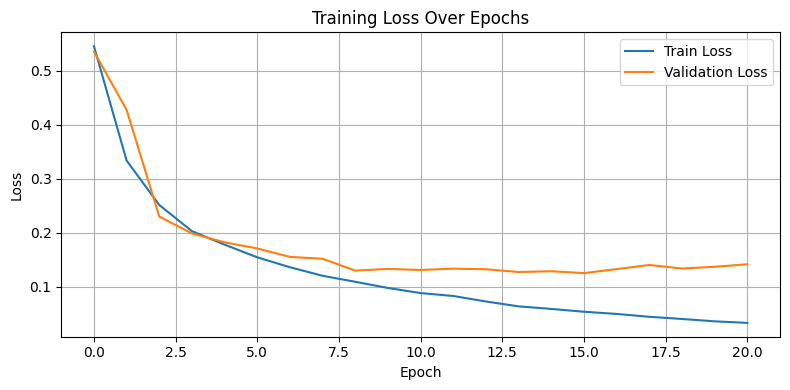

In [18]:
# ------------------------
# 9. Visualize Loss
# ------------------------
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# ------------------------
# 10. Save Model and Scaler
# ------------------------
model.save("lung_risk_model.keras")
joblib.dump(scaler, "lung_scaler.pkl")
print("\n✅ Model and scaler saved successfully.")


✅ Model and scaler saved successfully.
